# The Annotated Transformer

**References**: 
- The Annotated Transformer, 2018 (https://nlp.seas.harvard.edu/2018/04/03/attention.html)

**Purpose**: 
- The Attention is All You Need paper is very clearly written, but it's quite difficult to implement correctly.
- We want to improve translation quality of DL models as well as performance on NLP tasks.
- The goal of reducing sequential computation leads us to CNNs which compute hidden representations in parallel for all input and output positions. 
- The number of operations required to relate signals from two arbitrary input or output positions grows in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. 
- Problem: This makes it more difficult to learn dependencies between distant positions.


**Approach**: 
- The Annotated version of the paper has a line-by-line implementation.
- In the Transformer, the number of operations required to relate signals from two arbitrary input or output positions is reduced to a constant number of operations, albeit at the cost of reduced effective resolution due to averaging attention-weighted positions, an effect they counteract with Multi-Head Attention.

**Result**: 
- Full-implementation which composes of 400 lines of library code which can process 27K tokens / sec on 4 GPUs.
- Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence aligned RNNs or convolution (enabling parallelized computation instead of sequential - which is critical when highly efficient training).



**Definitions**: 
Self-attention/intra-attention = an attention mechanism relating different positions of a single sequence in order to compute a representaiton of the sequence

**Notes**:
- Self-attention had been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment andl earning task-indepeendent sentence representations. 
    - Note: it looks like self-attention was not a new idea, it had been proven already. The key insight was the scope of the problem because "we need to learn dependencies between distant positions without needing the number of operations to relate signals to grow in distance between positions" + what's SOTA in solving this problem right now (which is self-attention).
    - In fact, E2E memory networks based on recurrent attention mechanism instead of sequence aligned recurrence have been shown to perform well on simple-language Q&A and language modeling tasks.
        - Note: looks like the recurrent attention mechanism team didn't realize that they don't need the recurrent hidden state and can just process things in parallel instead of sequentially. This is where perspective and scope of the problem you care about really matters in helping you explore different options - the motivations are completely different.
    - Another big takeaway is that typically you "could" just say that scale will win and eventually learn all of these things, but parallelization and higher efficiency was actually necessary here to realize those gains earlier on.

**FAQs**:

**Takeaways**:
1. Note: looks like the recurrent attention mechanism team didn't realize that they don't need the recurrent hidden state and can just process things in parallel instead of sequentially. This is where perspective and scope of the problem you care about really matters in helping you explore different options - the motivations are completely different.
2. Another big takeaway is that typically you "could" just say that scale will win and eventually learn all of these things, but parallelization and higher efficiency was actually necessary here to realize larger scale and those gains.

**Action items**:


In [9]:
# !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib spacy torchtext seaborn 
!pip install numpy matplotlib spacy torchtext seaborn 
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
     ---------------------------------------- 0.0/68.0 kB ? eta -:--:--
     ---------------------------------------- 68.0/68.0 kB 1.9 MB/s eta 0:00:00
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached confection-0.1.5-py3-none-any.whl.metadata (19 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/14.9 MB ? 


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cpu
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.6 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------  1.6/1.6 MB 25.2 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 16.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------  2.5/2.5 MB 80.3 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 39.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [11]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many other models
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        """Take in and process masked src and target sequences."""
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [12]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab) # logits (unnormalized logits for each token)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1) # log-probs

# Encoder and Decoder Stacks

## Encoder
The encoder is composed of a stack of N = 6 identical layers.

In [13]:
def clones(module, N):
    """Produce N identical layers."""
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [16]:
class Encoder(nn.Module):
    """Core encoder is a stack of N layers"""
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        """Pass the input (and mask) through each layer in turn."""
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [15]:
class LayerNorm(nn.Module):
    """Construct a layernorm module."""
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2 # elementwise affine transformation

In [ ]:
# assume d_model=512

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm. Pre-Layernorm
    Note for code simplicity the norm is first as opposed to last. Also note: this is the classic method of a Pre-LayerNorm now which is empirically better than a Post-LayerNorm where
    def forward(self, x, sublayer):
        return self.norm(x + self.dropout(sublayer(x)))
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [ ]:
class EncoderLayer(nn.Module):
    "encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) # MHA
        return self.sublayer[1](x, self.feed_forward) # FF

## Decoder

The decoder is also composed of a stack of N = 6 identical layers.

In [17]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size) # d_model

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [18]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [19]:
def subsequent_mask(size):
    "Mask out subsequent posiitons."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8') # sets everything below the 1 upper triangle to 0
    return torch.from_numpy(subsequent_mask) == 0

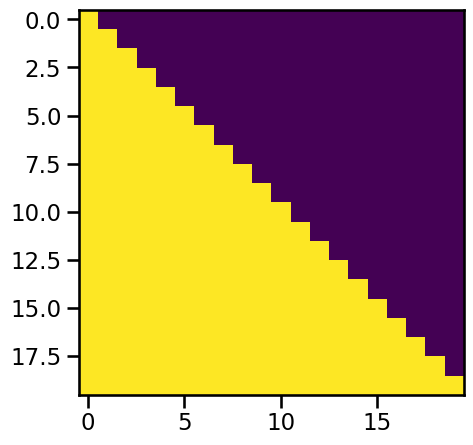

In [20]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

## Attention

Scaled Dot-Product Attention
Input: queries and keys of dimension d_k, values of dimension d_v

In [21]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) # affinities / compatibility function
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1) # weights
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. 

Employ h = 8 parallel attention layers/heads

d_k = d_v = d_model / h = 64

512 / 8 = 64

In [22]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4) # Wq, Wk, Wv, Wo
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)

        return self.linears[-1](x)

## Position-wise Feed-Forward Networks
Q: Do you need a mask for this FFN? Or I guess not? 
- A: No, the FFN just transforms one token embedding into another token embedding. That's it.

Another way of describing this is as two convolutions with kernel size 1, projecting it from some input embedding dimension 1 to output embedding dimension 1, and then another one to project to output embeding dimension 2

Input and output dimension = d_model = 512, inner-layer has d_ff = 2048 (512 * 4)

In [23]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embeddings and Softmax
norm = length / magnitude of a vector

Euclidean norm (L2 norm) = ||x||_2 = \sqrt(x_1^2 + x_2^2 + ... + x_n^2)

Remember, Mean(X) = E[X] and Var(X) = E[(X - E[X])^2]

When mean = 0, then Var(X) = E[X^2]

Expected Squared Norm = 

E[||e_tok||^2] = E[x_1^2] + E[x_2^2] + ... + E[x_d_model^2]

E[||e_tok||^2] = Var(x_1^2) + Var(x_2^2) + ... + Var(x_d_model^2)

E[||e_tok||^2] = 1

E[||e_tok||] = 1

Positional encodings also all have magnitude 1. 

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model) # lookup table where rows = vocabulary items size vocab and cols = embedding dimensions d_model. Note: nn.Embedding by default initializes each dimenion to have variance = 1/d_model s.t. expected vector norm = 1.
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model) # scaling to not have positional encodings dominate # the key reason why we scale is because many sublayers like attention product outputs with variance = 1 per dimension. Therefore, to get the embedding's per-dimension variance to be variance = 1 instead of 1/d_model, we need to multiply by \sqrt(self.d_model), assuming nn.Embedding initialized each dimension with variance 1/d_model so that the embedding vector norm = 1 # Therefore, we want all our vectors to have variance d_model.

## Positional Encoding

Positional encodings can be learned or fixed, we'll use fixed sine and consine functions of different frequencies: 

PE_{(pos,2i)} = sin(pos/10000**{2i/d_model})

PE_{(pos,2i+1)} = cos(pos/10000**{2i/d_model})

